# Cell Segmentation with UNETR

## Setup environment

In [1]:
# !pip3 install scikit-learn
# !pip install 'monai[nibabel, einops]'
# !pip3 install pytorch_lightning
# !pip install matplotlib pandas gdown lmdb scikit-image
# !pip install ipywidgets
# %matplotlib inline
# !pip install jedi

## **Setup imports**

In [1]:
import os
import sys
import shutil
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import ndimage
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torch.utils.tensorboard import SummaryWriter
from torch.nn import  MSELoss, Sigmoid
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import monai
from monai.losses import DiceCELoss
from monai.utils import set_determinism, first,MetricReduction
from monai.visualize import plot_2d_or_3d_image
from monai.losses import DiceCELoss,DiceLoss,GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.optimizers import Novograd
from monai.networks.layers import Norm
from monai.transforms import (
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
    Activations,
    NormalizeIntensityd,
    AsDiscrete,
    AddChanneld,
    RandSpatialCrop,
    RandSpatialCropSamplesd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    NormalizeIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    Resized,
    RandRotate90d,
    ToTensord,
    ThresholdIntensityd,
    RandHistogramShiftd,
    RandCoarseDropoutd,
    Rand3DElasticd,
    RandAffined,
    AdjustContrastd,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    CastToTyped,
    CopyItemsd,
    Lambdad,
    SaveImaged,
    EnsureTyped,
    SpatialPadd,
    RandCropByLabelClassesd,
    RandRotated,
    RandZoomd,
    RandGaussianSmoothd,
    RandScaleIntensityd,
    RandGaussianNoised,
    ToPIL,
    RandFlip,
    SaveImage
)
from monai.config import print_config
from monai.metrics import DiceMetric,MSEMetric,RMSEMetric
from monai.networks.nets import UNETR,UNet,SegResNet,BasicUNet,ResNet
from monai.data import (
    PILReader,
    DataLoader,
    Dataset,
    CacheDataset,
    PersistentDataset,
    load_decathlon_datalist,
    decollate_batch,
    list_data_collate,
    ThreadDataLoader,
)
from monai.data.utils import partition_dataset
from monai.apps import CrossValidation

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print_config()

MONAI version: 1.0.1
Numpy version: 1.23.4
Pytorch version: 1.13.0+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.11.0
gdown version: 4.5.3
TorchVision version: 0.14.0+cu117
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Visualisation of original imgs

In [2]:
image_0 = './dataset/imagesTr/1.0.jpg'
image_1 = './dataset/Set_1_Cam_AO_PI_19_02_16/1.1.jpg'
image_2 = './dataset/Set_1_Cam_AO_PI_19_02_16/1.2.jpg'
label = './dataset/labelsTr/1.3.jpg'

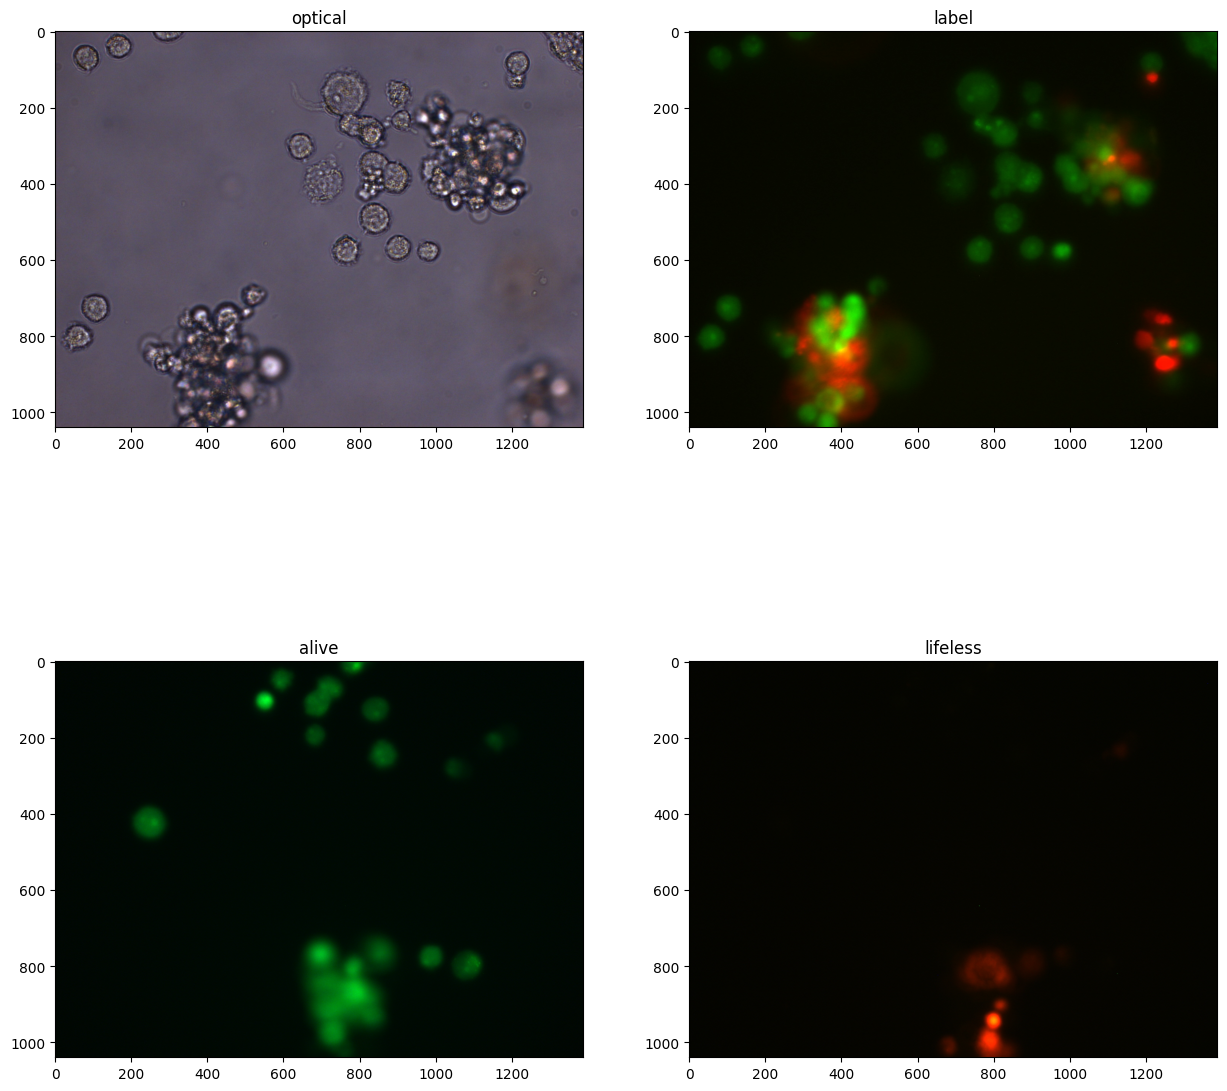

In [3]:
image_reader = PILReader()
img_0 = image_reader.read(image_0)
img_1 = image_reader.read(image_1)
img_2 = image_reader.read(image_2)
lbl = image_reader.read(label)

fig = plt.figure("check", (15, 15))
plt.subplot(221)
plt.title('optical')
plt.imshow(img_0)
plt.subplot(222)
plt.title('label')
plt.imshow(lbl)
plt.subplot(223)
plt.title('alive')
plt.imshow(img_1)
plt.subplot(224)
plt.title('lifeless')
plt.imshow(img_2)

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
root_dir=os.path.join(os.getcwd(), 'best_model/')
print(root_dir)

/home/best_model/


## Download dataset and format in the folder.


    1. Download dataset from here:
    2. Put images in the ./data/imagesTr
    3. Put labels in the ./data/labelsTr
    4. make JSON file accordingly: ./data/dataset_0.json

## Define the LightningModule (transform, network)
The LightningModule contains a refactoring of your training code. The following module is a refactoring of the code in spleen_segmentation_3d.ipynb:

In [5]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()

        self._model =UNet(
            spatial_dims=2,
            in_channels=3,
            out_channels=2,
            channels=(32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            dropout = 0.2,
        ).to(device)

        self.loss_function = MSELoss()
        self.best_val_loss = 1e8
        self.best_val_epoch = 0
    
        self.max_epochs = 700
        self.check_val = 10
        self.warmup_epochs = 5
        self.metric_values = []
        self.epoch_loss_values = []
        self.spatial_size = (512,512)

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # prepare data
        data_dir ='./dataset/'
        split_JSON = "dataset_0.json"
        datasets = data_dir + split_JSON
        datalist = load_decathlon_datalist(datasets, True, "training")
        val_files = load_decathlon_datalist(datasets, True, "validation")

        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),#, reader=PILReader()),

                EnsureChannelFirstd(keys=["image", "label"]),
                Lambdad(keys=["label"],
                        func=lambda image: ((image[0:2, 1:, :]).astype(torch.float32))/255.0,
                        overwrite=True,
                        ),
                #EnsureChannelFirstd(keys=["image"]),
                CastToTyped(keys=["label"], dtype=(torch.float32)),
                CastToTyped(keys=["image"], dtype=(torch.float32)),
                Resized(keys=["image", "label"], spatial_size=self.spatial_size),


                ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),

                CastToTyped(keys=["image", "label"], dtype=(np.float32, np.float32)),
                EnsureTyped(keys=["image", "label"]),
                CastToTyped(keys=["image"], dtype=(torch.float32)),
                #RandCropByPosNegLabeld(
                 #   keys=["image", "label"], 
                  #  label_key="label",
                   # spatial_size=spatial_size, 
                   # pos=1, neg=1, 
                   # num_samples=num_patches_per_image
                   # ),
                #RandSpatialCropSamplesd(keys=["image", "label"], roi_size=spatial_size , num_samples=2, random_size = False),
                RandRotated(keys=["image", "label"], range_x=0.3, range_y=0.3, range_z=0.3, mode=["bilinear", "nearest"], prob=0.2),
                RandGaussianSmoothd(keys=["image"], sigma_x=(0.5,1.15), sigma_y=(0.5,1.15), sigma_z=(0.5,1.15), prob=0.15),
                RandScaleIntensityd(keys=["image"], factors=0.2, prob=0.5),
                RandShiftIntensityd(keys=["image"], offsets=0.05, prob=0.5),
                RandGaussianNoised(keys=["image"], std=0.01, prob=0.15),
                RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.5),
                RandFlipd(keys=["image", "label"], spatial_axis=1, prob=0.5),
                CastToTyped(keys=["image", "label"], dtype=(torch.float32, torch.float32)),
                ToTensord(keys=["image", "label"]),
            ]
        )
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),#, reader=PILReader()),
                EnsureChannelFirstd(keys=["image", "label"]),
                Lambdad(keys=["label"],
                        func=lambda image: ((image[0:2, 1:, :]).astype(torch.float32))/255.0,
                        overwrite=True,
                        ),

                CastToTyped(keys=["label"], dtype=(torch.float32)),


                CastToTyped(keys=["image"], dtype=(torch.float32)),
                Resized(keys=["image", "label"], spatial_size=self.spatial_size),

                ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),

                CastToTyped(keys=["image", "label"], dtype=(np.float32, np.float32)),
                EnsureTyped(keys=["image", "label"]),
                #ToTensord(keys=["image", "label"])
            ]
        )

        self.train_ds = CacheDataset(
            data=datalist,
            transform=train_transforms,
            cache_num=15,
            cache_rate=1.0,
            num_workers=5,
        )
        self.val_ds = CacheDataset(
            data=val_files,
            transform=val_transforms,
            cache_num=5,
            cache_rate=1.0,
            num_workers=5,
        )

    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_ds,
            batch_size=1,
            shuffle=True,
            num_workers=5,
            pin_memory=True,
            collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(
            self.val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
        )
        return val_loader

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self._model.parameters(), lr=1e-4, weight_decay=1e-5
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = (batch["image"].cuda(), batch["label"].cuda())
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        self.log("train_loss", loss.item())
        return {"loss": loss, "log": tensorboard_logs}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.epoch_loss_values.append(avg_loss.detach().cpu().numpy())
    
    def validation_step(self, batch, batch_idx):
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y = torch.tensor([], dtype=torch.float32, device=device)
        images, labels = batch["image"], batch["label"]
        outputs = torch.cat([y_pred, self._model(images)], dim=0)
        #outputs = model(images)
        labels = torch.cat([y, labels], dim=0)
        loss = self.loss_function(outputs,labels)

        #torch.cat([y_pred, model(images)], dim=0)
        #outputs = model(images)
        #labels = torch.cat([y, labels], dim=0)

        if batch_idx == 0:
            sr = SummaryWriter(log_dir=self.logger.log_dir)
            plot_2d_or_3d_image(images, self.current_epoch + 1, sr, max_channels=3, index=0, tag="image")
            plot_2d_or_3d_image(labels, self.current_epoch + 1, sr, max_channels=3,index=0, tag="label")
            plot_2d_or_3d_image(outputs, self.current_epoch + 1, sr, max_channels=3, index=0, tag="output")
        return {"val_loss": loss, "val_number": len(outputs)}

    def validation_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]


        mean_val_loss = val_loss / num_items
        tensorboard_logs = {
            "val_loss": mean_val_loss,
        }
        
        if self.best_val_loss > mean_val_loss:
            self.best_val_loss = mean_val_loss
            self.best_val_epoch = self.current_epoch
            torch.save(self._model.state_dict(), "best_loss.pth")
            print("saved new best metric model")
        print(
            "current epoch: {}  current loss: {:.4f}  best loss: {:.4f} at epoch {}".format(
                self.current_epoch, mean_val_loss , self.best_val_loss, self.best_val_epoch
                )
            )
        self.log("val_loss", mean_val_loss)  
        return {"log": tensorboard_logs}

## Run the training

In [6]:
# initialise the LightningModule
net = Net()

# set up checkpoints
checkpoint_callback = ModelCheckpoint(dirpath=root_dir, filename="best_metric_model", save_last=True)

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    precision=16,
    accelerator='gpu', 
    devices=[0],
    max_epochs=net.max_epochs,
    check_val_every_n_epoch=net.check_val,
    callbacks=checkpoint_callback,
    default_root_dir=root_dir,
    accumulate_grad_batches=4,
)

# train
trainer.fit(net)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Loading dataset: 100%|██████████| 5/5 [00:00<00:00, 39.88it/s]
Missing logger folder: /home/best_model/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | _model        | UNet    | 6.5 M 
1 | loss_function | MSELoss | 0     
------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
12.993    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 0  current loss: 0.7189  best loss: 0.7189 at epoch 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 9  current loss: 0.0564  best loss: 0.0564 at epoch 9


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 19  current loss: 0.0359  best loss: 0.0359 at epoch 19


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 29  current loss: 0.0251  best loss: 0.0251 at epoch 29


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 39  current loss: 0.0183  best loss: 0.0183 at epoch 39


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 49  current loss: 0.0147  best loss: 0.0147 at epoch 49


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 59  current loss: 0.0125  best loss: 0.0125 at epoch 59


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 69  current loss: 0.0118  best loss: 0.0118 at epoch 69


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 79  current loss: 0.0111  best loss: 0.0111 at epoch 79


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 89  current loss: 0.0110  best loss: 0.0110 at epoch 89


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 99  current loss: 0.0108  best loss: 0.0108 at epoch 99


Validation: 0it [00:00, ?it/s]

current epoch: 109  current loss: 0.0108  best loss: 0.0108 at epoch 99


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 119  current loss: 0.0106  best loss: 0.0106 at epoch 119


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 129  current loss: 0.0106  best loss: 0.0106 at epoch 129


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 139  current loss: 0.0105  best loss: 0.0105 at epoch 139


Validation: 0it [00:00, ?it/s]

current epoch: 149  current loss: 0.0107  best loss: 0.0105 at epoch 139


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 159  current loss: 0.0104  best loss: 0.0104 at epoch 159


Validation: 0it [00:00, ?it/s]

current epoch: 169  current loss: 0.0105  best loss: 0.0104 at epoch 159


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 179  current loss: 0.0103  best loss: 0.0103 at epoch 179


Validation: 0it [00:00, ?it/s]

current epoch: 189  current loss: 0.0105  best loss: 0.0103 at epoch 179


Validation: 0it [00:00, ?it/s]

current epoch: 199  current loss: 0.0105  best loss: 0.0103 at epoch 179


Validation: 0it [00:00, ?it/s]

current epoch: 209  current loss: 0.0105  best loss: 0.0103 at epoch 179


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 219  current loss: 0.0102  best loss: 0.0102 at epoch 219


Validation: 0it [00:00, ?it/s]

current epoch: 229  current loss: 0.0103  best loss: 0.0102 at epoch 219


Validation: 0it [00:00, ?it/s]

current epoch: 239  current loss: 0.0107  best loss: 0.0102 at epoch 219


Validation: 0it [00:00, ?it/s]

current epoch: 249  current loss: 0.0108  best loss: 0.0102 at epoch 219


Validation: 0it [00:00, ?it/s]

current epoch: 259  current loss: 0.0103  best loss: 0.0102 at epoch 219


Validation: 0it [00:00, ?it/s]

current epoch: 269  current loss: 0.0103  best loss: 0.0102 at epoch 219


Validation: 0it [00:00, ?it/s]

current epoch: 279  current loss: 0.0102  best loss: 0.0102 at epoch 219


Validation: 0it [00:00, ?it/s]

current epoch: 289  current loss: 0.0104  best loss: 0.0102 at epoch 219


Validation: 0it [00:00, ?it/s]

current epoch: 299  current loss: 0.0102  best loss: 0.0102 at epoch 219


Validation: 0it [00:00, ?it/s]

current epoch: 309  current loss: 0.0103  best loss: 0.0102 at epoch 219


Validation: 0it [00:00, ?it/s]

current epoch: 319  current loss: 0.0104  best loss: 0.0102 at epoch 219


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 329  current loss: 0.0101  best loss: 0.0101 at epoch 329


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 339  current loss: 0.0101  best loss: 0.0101 at epoch 339


Validation: 0it [00:00, ?it/s]

current epoch: 349  current loss: 0.0102  best loss: 0.0101 at epoch 339


Validation: 0it [00:00, ?it/s]

current epoch: 359  current loss: 0.0102  best loss: 0.0101 at epoch 339


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 369  current loss: 0.0101  best loss: 0.0101 at epoch 369


Validation: 0it [00:00, ?it/s]

current epoch: 379  current loss: 0.0102  best loss: 0.0101 at epoch 369


Validation: 0it [00:00, ?it/s]

current epoch: 389  current loss: 0.0102  best loss: 0.0101 at epoch 369


Validation: 0it [00:00, ?it/s]

current epoch: 399  current loss: 0.0101  best loss: 0.0101 at epoch 369


Validation: 0it [00:00, ?it/s]

current epoch: 409  current loss: 0.0102  best loss: 0.0101 at epoch 369


Validation: 0it [00:00, ?it/s]

current epoch: 419  current loss: 0.0101  best loss: 0.0101 at epoch 369


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 429  current loss: 0.0099  best loss: 0.0099 at epoch 429


Validation: 0it [00:00, ?it/s]

current epoch: 439  current loss: 0.0100  best loss: 0.0099 at epoch 429


Validation: 0it [00:00, ?it/s]

current epoch: 449  current loss: 0.0101  best loss: 0.0099 at epoch 429


Validation: 0it [00:00, ?it/s]

current epoch: 459  current loss: 0.0100  best loss: 0.0099 at epoch 429


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 469  current loss: 0.0099  best loss: 0.0099 at epoch 469


Validation: 0it [00:00, ?it/s]

current epoch: 479  current loss: 0.0101  best loss: 0.0099 at epoch 469


Validation: 0it [00:00, ?it/s]

current epoch: 489  current loss: 0.0101  best loss: 0.0099 at epoch 469


Validation: 0it [00:00, ?it/s]

current epoch: 499  current loss: 0.0101  best loss: 0.0099 at epoch 469


Validation: 0it [00:00, ?it/s]

current epoch: 509  current loss: 0.0101  best loss: 0.0099 at epoch 469


Validation: 0it [00:00, ?it/s]

current epoch: 519  current loss: 0.0101  best loss: 0.0099 at epoch 469


Validation: 0it [00:00, ?it/s]

current epoch: 529  current loss: 0.0100  best loss: 0.0099 at epoch 469


Validation: 0it [00:00, ?it/s]

current epoch: 539  current loss: 0.0103  best loss: 0.0099 at epoch 469


Validation: 0it [00:00, ?it/s]

current epoch: 549  current loss: 0.0099  best loss: 0.0099 at epoch 469


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 559  current loss: 0.0098  best loss: 0.0098 at epoch 559


Validation: 0it [00:00, ?it/s]

current epoch: 569  current loss: 0.0101  best loss: 0.0098 at epoch 559


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 579  current loss: 0.0098  best loss: 0.0098 at epoch 579


Validation: 0it [00:00, ?it/s]

current epoch: 589  current loss: 0.0100  best loss: 0.0098 at epoch 579


Validation: 0it [00:00, ?it/s]

current epoch: 599  current loss: 0.0100  best loss: 0.0098 at epoch 579


Validation: 0it [00:00, ?it/s]

current epoch: 609  current loss: 0.0101  best loss: 0.0098 at epoch 579


Validation: 0it [00:00, ?it/s]

current epoch: 619  current loss: 0.0099  best loss: 0.0098 at epoch 579


Validation: 0it [00:00, ?it/s]

current epoch: 629  current loss: 0.0099  best loss: 0.0098 at epoch 579


Validation: 0it [00:00, ?it/s]

current epoch: 639  current loss: 0.0098  best loss: 0.0098 at epoch 579


Validation: 0it [00:00, ?it/s]

current epoch: 649  current loss: 0.0099  best loss: 0.0098 at epoch 579


Validation: 0it [00:00, ?it/s]

current epoch: 659  current loss: 0.0102  best loss: 0.0098 at epoch 579


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 669  current loss: 0.0097  best loss: 0.0097 at epoch 669


Validation: 0it [00:00, ?it/s]

current epoch: 679  current loss: 0.0097  best loss: 0.0097 at epoch 669


Validation: 0it [00:00, ?it/s]

saved new best metric model
current epoch: 689  current loss: 0.0096  best loss: 0.0096 at epoch 689


Validation: 0it [00:00, ?it/s]

current epoch: 699  current loss: 0.0096  best loss: 0.0096 at epoch 689


`Trainer.fit` stopped: `max_epochs=700` reached.


### Plot the loss and metric

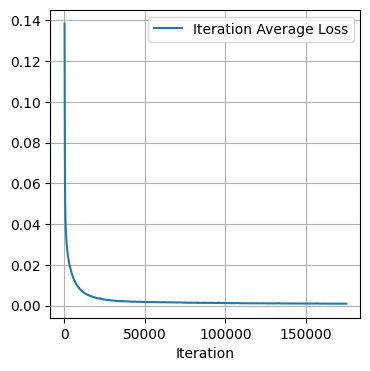

In [8]:
eval_num = 250
plt.figure("train", (4, 4))
# plt.title("Iteration Average Loss")
x1 = [eval_num * (i + 1) for i in range(len(net.epoch_loss_values))]
y1 = net.epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x1, y1, label='Iteration Average Loss')
plt.grid(True)
plt.legend()
# plt.savefig(os.path.join(os.getcwd(), 'graphs', "avg_loss6.svg"), format = "svg", bbox_inches='tight')
plt.show()

# plt.figure("train", (4, 4))
# # plt.title("Iteration Average Loss")
# x2 = [eval_num * (i + 1) for i in range(len(net.metric_values))]
# y2 = net.metric_values
# plt.xlabel("Iteration")
# plt.plot(x2, y2, label='Validation Mean Dice')
# plt.grid(True)
# plt.legend()
# # plt.savefig(os.path.join(os.getcwd(), 'graphs', "val_mean_dis6.svg"), format = "svg", bbox_inches='tight')
# plt.show()

In [ ]:
d = {'Iteration 0': x1, 'Iteration Average Loss 0': y1}
df1 = pd.DataFrame(data=d)
# df1 = pd.read_csv(os.path.join(os.getcwd(), 'results_csvs', "avg_loss.csv"), index_col=0)
df1['Iteration 1'] = x1
df1['Iteration Average Loss 1'] = y1
# df1.to_csv(os.path.join(os.getcwd(), 'results_csvs', "avg_loss6.csv"))

d = {'Iteration 0': x2, 'Validation Mean Dice 0': y2}
df2 = pd.DataFrame(data=d)
# df2 = pd.read_csv(os.path.join(os.getcwd(), 'results_csvs', "val_mean_dis.csv"), index_col=0)
df2['Iteration 1'] = x2
df2['Iteration Average Loss 1'] = y2
# df2.to_csv(os.path.join(os.getcwd(), 'results_csvs', "val_mean_dis6.csv"))

### Check best model output with the input image and label

In [8]:
root_dir=os.path.join(os.getcwd(), 'best_model/')

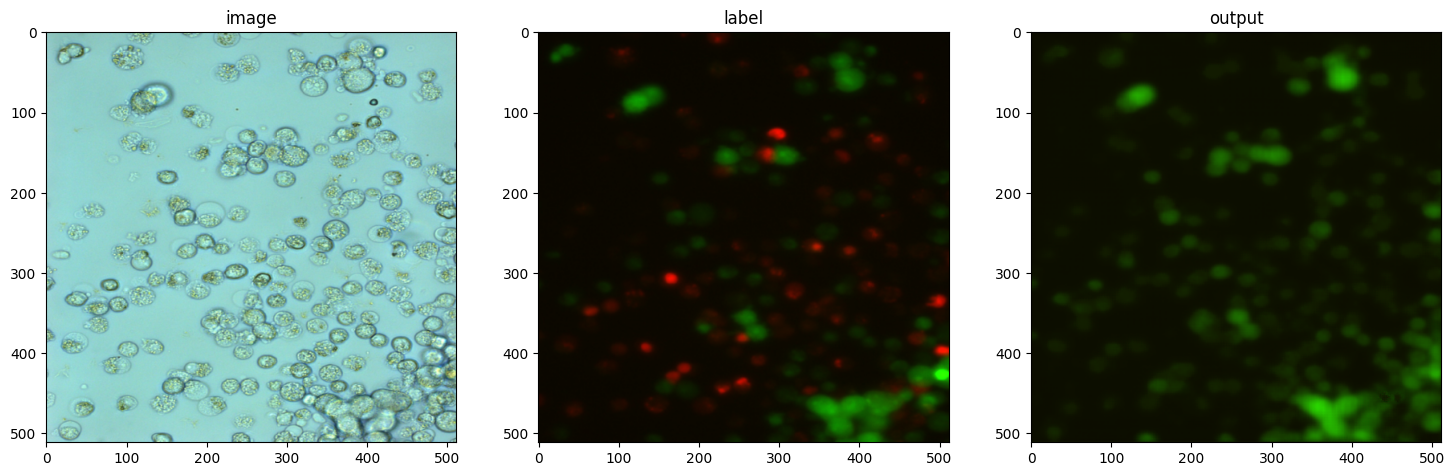

In [32]:
y = torch.zeros(1, 512, 512)
transform = T.ToPILImage()
case_num = 8
model = Net.load_from_checkpoint(os.path.join(root_dir, "best_metric_model-v1.ckpt"))
model.eval()
model.to(device)

with torch.no_grad():
    img_name = os.path.split(
        net.val_ds[case_num]["image"].meta["filename_or_obj"]
    )[1]
    img = net.val_ds[case_num]["image"]
    label = net.val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 0).cuda()
    val_labels = torch.unsqueeze(label, 0).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (512, 512), 1, model)
    
    img_val_inputs = transform(val_inputs.detach().cpu()[0])
    img_val_labels = transform(torch.vstack((val_labels.detach().cpu()[0],y)))
    img_val_outputs = transform(torch.vstack((val_outputs.detach().cpu()[0],y)))
    
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(img_val_inputs)
    plt.subplot(1, 3, 2)
    plt.title(f"label")
    plt.imshow(img_val_labels)
    plt.subplot(1, 3, 3)
    plt.title(f"output")
    plt.imshow(img_val_outputs)
#     plt.savefig(os.path.join(os.getcwd(), 'graphs', "img_results1.svg"), format = "svg", bbox_inches='tight')
    plt.show()

In [11]:
val_inputs.shape

(1, 3, 512, 512)

In [12]:
val_labels.shape

(1, 2, 512, 512)

In [13]:
val_outputs.shape

(1, 2, 512, 512)

### Check Loss

In [45]:
loss = MSELoss()
input = val_labels[0][1]
target = val_outputs[0][1]
output = loss(input, target)
print(f'MSELoss live={output.cpu().numpy()}')

MSELoss live=0.0032902469392865896


### Cleanup data directory

Remove directory if a temporary was used.

In [30]:
# shutil.rmtree(root_dir)